In [1]:
import pandas as pd
import torch
import seaborn as sb

In [2]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils_train
import config.constants_10x as const

from tcr_embedding.utils_preprocessing import stratified_group_shuffle_split, group_shuffle_split
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.evaluation.kNN import run_knn_within_set_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function

from tcr_embedding.models.model_selection_count_prediction import DecisionHead

In [3]:
def embed_data(adata, path_model, key_counts):
    model = utils_train.load_model(adata, path_model)
    embedding = model.get_latent(adata, metadata=['set'], return_mean=True)
    embedding.obsm[key_counts] = adata.obsm[key_counts]
    return embedding


def get_training_data(embedding, key_counts):
    mask_train = embedding.obs['set'] == 'train'
    x_train = embedding.X[mask_train]
    y_train = embedding.obsm[key_counts][mask_train].toarray()

    mask_val = embedding.obs['set'] == 'val'
    x_val = embedding.X[mask_val]
    y_val = embedding.obsm[key_counts][mask_val].toarray()
    return CustomDataset(x_train, y_train), CustomDataset(x_val, y_val) 

In [4]:
def load_10x_data(donor, split):
    adata = utils_train.load_data('10x')
    adata = adata[adata.obs['donor'] == f'donor_{donor}']
    adata = adata[adata.obs['binding_name'].isin(const.HIGH_COUNT_ANTIGENS)]
    if split != 'full':
        random_seed = split

        train_val, test = group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=random_seed)
        train, val = group_shuffle_split(train_val, group_col='clonotype', val_split=0.25, random_seed=random_seed)

        adata.obs['set'] = 'train'
        adata.obs.loc[val.obs.index, 'set'] = 'val'
        adata.obs.loc[test.obs.index, 'set'] = 'test'
        adata = adata[adata.obs['set'].isin(['train', 'val', 'test'])]
    return adata

In [5]:
def load_avidity_model(donor, split, model_name):
    path_checkpoint = f'../mvTCR/saved_models/journal/10x/avidity_prediction/'
    path_checkpoint += f'10x_avidity_{model_name}_{donor}_{split}.ckpt'
    checkpoint = torch.load(path_checkpoint)
    model = DecisionHead.load_from_checkpoint(checkpoint_path=path_checkpoint)
    return model

In [6]:
def msle(x_pred, x_true):
    log_pred = torch.log(x_pred+1)
    log_true = torch.log(x_true+1)
    error = torch.nn.MSELoss()(log_pred, log_true)
    return error.detach().numpy().item()

In [7]:
import sklearn
def r2(x_pred, x_true):
    log_pred = torch.log(x_pred+1).detach().numpy()
    log_true = torch.log(x_true+1).detach().numpy()
    r2 = sklearn.metrics.r2_score(log_true, log_pred)
    return r2

In [8]:
donor = 1
metadata = ['binding_name', 'clonotype', 'donor']

model_names = []
splits = []
metrics = []
scores = []

for split in range(0, 5):
    adata = load_10x_data(donor, split)
    for model_name in ['moe',  'poe', 'concat', 'tcr', 'rna']:
        print(f'split: {split},  model: {model_name}')
        
        path_model_emb = f'saved_models/journal/10x/splits/donor_{donor}/{model_name}/'
        path_model_emb += f'{model_name}_donor_{donor}_split_{split}.pt'
        
        embedded_data = embed_data(adata, path_model_emb, 'binding_counts')
        embedded_data = embedded_data[embedded_data.obs['set']=='test']
        model = load_avidity_model(donor, split, model_name)
        embedded_data_torch = torch.from_numpy(embedded_data.X)
        
        count_prediction = model(embedded_data_torch)
        count_truth = embedded_data.obsm['binding_counts']
        count_truth = torch.from_numpy(count_truth)
        
        
        model_names += [model_name] * (adata.obsm['binding_counts'].shape[1]+1)*2
        splits += [split] * (adata.obsm['binding_counts'].shape[1]+1)*2
        
        for i, binding in enumerate(const.HIGH_COUNT_ANTIGENS):
            msle_val = msle(count_prediction[:, i], count_truth[:, i])
            metrics.append(f'MSLE_{binding}')
            scores.append(msle_val)
        msle_val = msle(count_prediction, count_truth)
        metrics += ['MSLE_total']
        scores += [msle_val]
        
        for i, binding in enumerate(const.HIGH_COUNT_ANTIGENS):
            r2_val = r2(count_prediction[:, i], count_truth[:, i])
            metrics.append(f'R2_{binding}')
            scores.append(r2_val)
        r2_val = r2(count_prediction, count_truth)
        metrics.append(f'R2_total')
        scores.append(r2_val)
        

results_10x_1 = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results_10x_1 = pd.DataFrame(results_10x_1)
results_10x_1.to_csv('../results/performance_avidity_10x_donor_1.csv')
results_10x_1

split: 0,  model: moe
{'activation': 'leakyrelu', 'dropout': 0.3, 'batch_norm': True, 'hidden_layers': [700, 700, 700, 700, 700]}
split: 0,  model: poe
{'activation': 'leakyrelu', 'dropout': 0.2, 'batch_norm': True, 'hidden_layers': [700, 700, 700, 700, 700]}
split: 0,  model: concat
{'activation': 'leakyrelu', 'dropout': 0.0, 'batch_norm': True, 'hidden_layers': [900, 900, 900, 900, 900]}
split: 0,  model: tcr
{'activation': 'leakyrelu', 'dropout': 0.0, 'batch_norm': True, 'hidden_layers': [900, 900, 900, 900, 900]}
split: 0,  model: rna
{'activation': 'leakyrelu', 'dropout': 0.05, 'batch_norm': True, 'hidden_layers': [900, 900, 900, 900]}
split: 1,  model: moe
{'activation': 'leakyrelu', 'dropout': 0.05, 'batch_norm': True, 'hidden_layers': [600, 600, 600, 600, 600]}
split: 1,  model: poe
{'activation': 'leakyrelu', 'dropout': 0.05, 'batch_norm': True, 'hidden_layers': [1000, 1000, 1000, 1000, 1000]}
split: 1,  model: concat
{'activation': 'leakyrelu', 'dropout': 0.25, 'batch_norm': 

,model,split,metrics,scores
0,moe,0,MSLE_A0201_ELAGIGILTV_MART-1_Cancer_binder,0.320998
1,moe,0,MSLE_A0201_GILGFVFTL_Flu-MP_Influenza_binder,1.651680
2,moe,0,MSLE_A0201_GLCTLVAML_BMLF1_EBV_binder,0.048991
3,moe,0,MSLE_A0301_KLGGALQAK_IE-1_CMV_binder,1.052770
4,moe,0,MSLE_A0301_RLRAEAQVK_EMNA-3A_EBV_binder,0.839244
...,...,...,...,...
445,rna,4,R2_A0301_RLRAEAQVK_EMNA-3A_EBV_binder,0.302785
446,rna,4,R2_A1101_IVTDFSVIK_EBNA-3B_EBV_binder,-4.899628
447,rna,4,R2_A1101_AVFDRKSDAK_EBNA-3B_EBV_binder,0.149458
448,rna,4,R2_B0801_RAKFKQLL_BZLF1_EBV_binder,0.001975


model
concat    2.050486
moe       1.958354
poe       2.027143
rna       2.034138
tcr       1.800301
Name: scores, dtype: float64

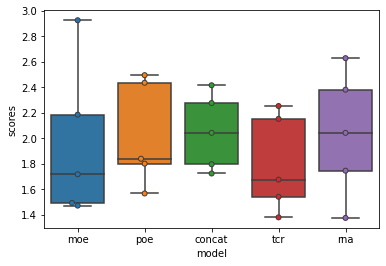

In [9]:
plot = sb.boxplot(data=results_10x_1[results_10x_1['metrics']=='MSLE_total'], y='scores', x='model')
sb.swarmplot(data=results_10x_1[results_10x_1['metrics']=='MSLE_total'], y='scores', x='model', 
             linewidth=1, edgecolor='gray')
results_10x_1[results_10x_1['metrics']=='MSLE_total'].groupby(['model'])['scores'].mean()

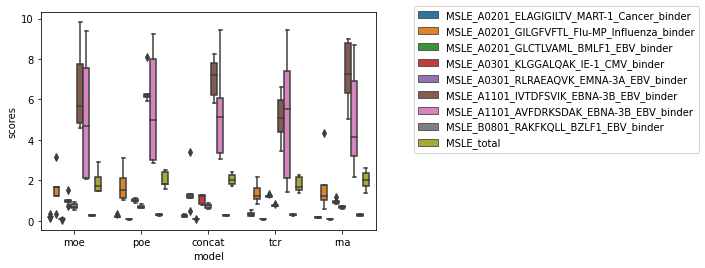

In [10]:
plot = sb.boxplot(data=results_10x_1[results_10x_1['metrics'].str.startswith('MSLE')], y='scores', x='model', 
                  hue='metrics')
#plot.set(ylim=(0, 2))
plot.legend(bbox_to_anchor=(1.1, 1.05))

model
concat   -0.629617
moe      -0.528716
poe      -0.541511
rna      -0.589847
tcr      -0.441784
Name: scores, dtype: float64

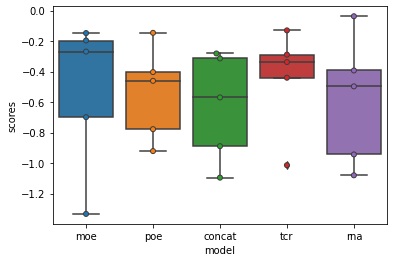

In [11]:
plot = sb.boxplot(data=results_10x_1[results_10x_1['metrics']=='R2_total'], y='scores', x='model')
sb.swarmplot(data=results_10x_1[results_10x_1['metrics']=='R2_total'], y='scores', x='model', 
             linewidth=1, edgecolor='gray')
results_10x_1[results_10x_1['metrics']=='R2_total'].groupby(['model'])['scores'].mean()

model
concat   -0.629617
moe      -0.528716
poe      -0.541511
rna      -0.589847
tcr      -0.441784
Name: scores, dtype: float64

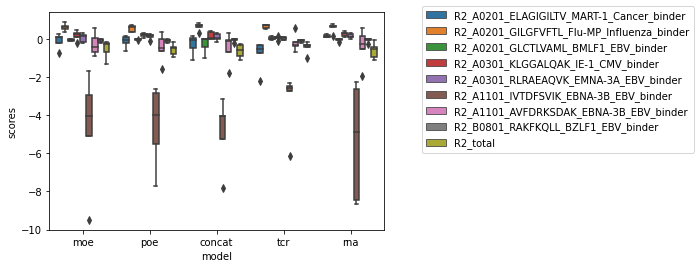

In [12]:
plot = sb.boxplot(data=results_10x_1[results_10x_1['metrics'].str.startswith('R2')], y='scores', x='model', 
                  hue='metrics')
#plot.set(ylim=(0, 2))
plot.legend(bbox_to_anchor=(1.1, 1.05))
results_10x_1[results_10x_1['metrics']=='R2_total'].groupby('model')['scores'].mean()

In [13]:
donor = 2
metadata = ['binding_name', 'clonotype', 'donor']

model_names = []
splits = []
metrics = []
scores = []

for split in range(0, 5):
    adata = load_10x_data(donor, split)
    for model_name in ['moe', 'poe', 'concat', 'tcr', 'rna']:
        print(f'split: {split},  model: {model_name}')
        
        path_model_emb = f'saved_models/journal/10x/splits/donor_{donor}/{model_name}/'
        path_model_emb += f'{model_name}_donor_{donor}_split_{split}.pt'
        
        embedded_data = embed_data(adata, path_model_emb, 'binding_counts')
        embedded_data = embedded_data[embedded_data.obs['set']=='test']
        model = load_avidity_model(donor, split, model_name)
        embedded_data_torch = torch.from_numpy(embedded_data.X)
        
        count_prediction = model(embedded_data_torch)
        count_truth = embedded_data.obsm['binding_counts']
        count_truth = torch.from_numpy(count_truth)
        
        model_names += [model_name] * (adata.obsm['binding_counts'].shape[1]+1)*2
        splits += [split] * (adata.obsm['binding_counts'].shape[1]+1)*2
        
        for i, binding in enumerate(const.HIGH_COUNT_ANTIGENS):
            msle_val = msle(count_prediction[:, i], count_truth[:, i])
            metrics.append(f'MSLE_{binding}')
            scores.append(msle_val)
        msle_val = msle(count_prediction, count_truth)
        metrics += ['MSLE_total']
        scores += [msle_val]
        
        for i, binding in enumerate(const.HIGH_COUNT_ANTIGENS):
            r2_val = r2(count_prediction[:, i], count_truth[:, i])
            metrics.append(f'R2_{binding}')
            scores.append(r2_val)
        r2_val = r2(count_prediction, count_truth)
        metrics.append(f'R2_total')
        scores.append(r2_val)

        

results_10x_2 = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results_10x_2 = pd.DataFrame(results_10x_2)
results_10x_2.to_csv('../results/performance_avidity_10x_donor_2.csv')
results_10x_2.head()

split: 0,  model: moe
{'activation': 'leakyrelu', 'dropout': 0.05, 'batch_norm': True, 'hidden_layers': [500, 500, 500, 500, 500]}
split: 0,  model: poe
{'activation': 'leakyrelu', 'dropout': 0.2, 'batch_norm': True, 'hidden_layers': [300, 300, 300, 300]}
split: 0,  model: concat
{'activation': 'leakyrelu', 'dropout': 0.05, 'batch_norm': True, 'hidden_layers': [400, 400, 400, 400, 400]}
split: 0,  model: tcr
{'activation': 'leakyrelu', 'dropout': 0.05, 'batch_norm': True, 'hidden_layers': [800, 800, 800]}
split: 0,  model: rna
{'activation': 'leakyrelu', 'dropout': 0.2, 'batch_norm': True, 'hidden_layers': [800, 800, 800]}
split: 1,  model: moe
{'activation': 'leakyrelu', 'dropout': 0.25, 'batch_norm': True, 'hidden_layers': [100, 100, 100, 100, 100]}
split: 1,  model: poe
{'activation': 'leakyrelu', 'dropout': 0.3, 'batch_norm': True, 'hidden_layers': [100, 100, 100, 100]}
split: 1,  model: concat
{'activation': 'leakyrelu', 'dropout': 0.25, 'batch_norm': True, 'hidden_layers': [600, 

,model,split,metrics,scores
0,moe,0,MSLE_A0201_ELAGIGILTV_MART-1_Cancer_binder,0.036063
1,moe,0,MSLE_A0201_GILGFVFTL_Flu-MP_Influenza_binder,1.004984
2,moe,0,MSLE_A0201_GLCTLVAML_BMLF1_EBV_binder,0.618737
3,moe,0,MSLE_A0301_KLGGALQAK_IE-1_CMV_binder,0.843677
4,moe,0,MSLE_A0301_RLRAEAQVK_EMNA-3A_EBV_binder,0.591764


model
concat    0.929760
moe       0.755507
poe       0.812282
rna       0.980055
tcr       0.834015
Name: scores, dtype: float64

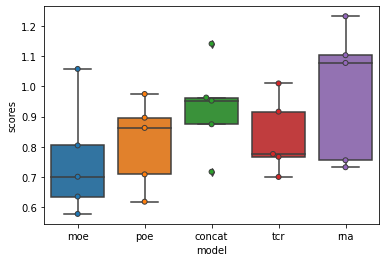

In [14]:
plot = sb.boxplot(data=results_10x_2[results_10x_2['metrics']=='MSLE_total'], y='scores', x='model')
sb.swarmplot(data=results_10x_2[results_10x_2['metrics']=='MSLE_total'], y='scores', x='model', 
             linewidth=1, edgecolor='gray')
results_10x_2[results_10x_2['metrics']=='MSLE_total'].groupby(['model'])['scores'].mean()

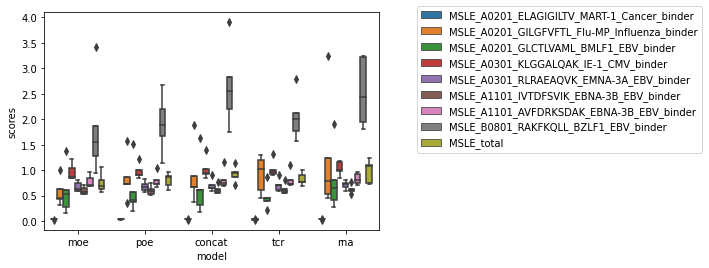

In [15]:
plot = sb.boxplot(data=results_10x_2[results_10x_2['metrics'].str.startswith('MSLE')], y='scores', x='model', 
                  hue='metrics')
#plot.set(ylim=(0, 2))
plot.legend(bbox_to_anchor=(1.1, 1.05))

model
concat    0.179563
moe       0.243959
poe       0.208639
rna       0.134407
tcr       0.205745
Name: scores, dtype: float64

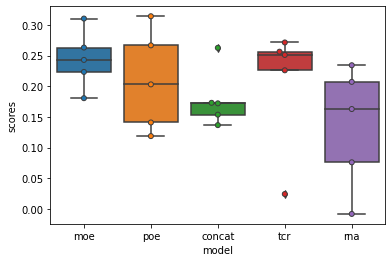

In [16]:
plot = sb.boxplot(data=results_10x_2[results_10x_2['metrics']=='R2_total'], y='scores', x='model')
sb.swarmplot(data=results_10x_2[results_10x_2['metrics']=='R2_total'], y='scores', x='model', 
             linewidth=1, edgecolor='gray')
results_10x_2[results_10x_2['metrics']=='R2_total'].groupby(['model'])['scores'].mean()

model
concat    0.179563
moe       0.243959
poe       0.208639
rna       0.134407
tcr       0.205745
Name: scores, dtype: float64

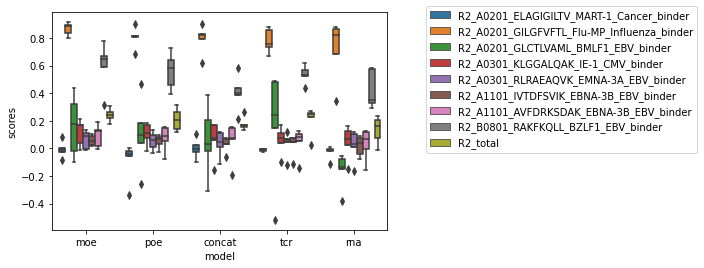

In [17]:
plot = sb.boxplot(data=results_10x_2[results_10x_2['metrics'].str.startswith('R2')], y='scores', x='model', 
                  hue='metrics')
#plot.set(ylim=(0, 2))
plot.legend(bbox_to_anchor=(1.1, 1.05))
results_10x_2[results_10x_2['metrics']=='R2_total'].groupby('model')['scores'].mean()

## Join Results

In [18]:
results_10x_1['donor'] = 'Donor_1'
results_10x_2['donor'] = 'Donor_2'
results_total = pd.concat([results_10x_1, results_10x_2])

model
concat    1.490123
moe       1.356930
poe       1.419713
rna       1.507096
tcr       1.317158
Name: scores, dtype: float64

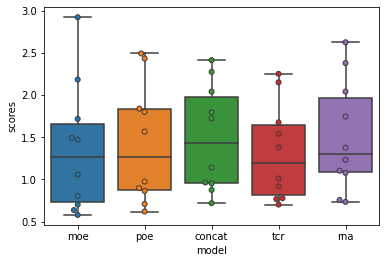

In [19]:
plot = sb.boxplot(data=results_total[results_total['metrics']=='MSLE_total'], y='scores', x='model')
sb.swarmplot(data=results_total[results_total['metrics']=='MSLE_total'], y='scores', x='model', 
             linewidth=1, edgecolor='gray')
results_total[results_total['metrics']=='MSLE_total'].groupby(['model'])['scores'].mean()

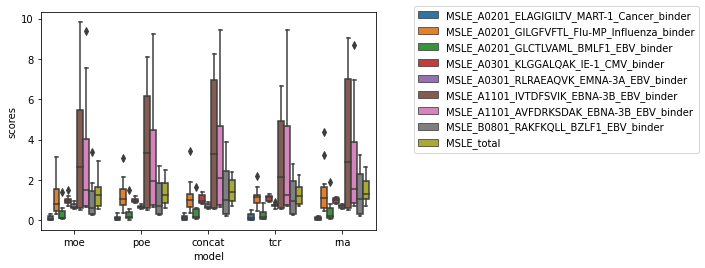

In [20]:
plot = sb.boxplot(data=results_total[results_total['metrics'].str.startswith('MSLE')], y='scores', x='model', 
                  hue='metrics')
#plot.set(ylim=(0, 2))
plot.legend(bbox_to_anchor=(1.1, 1.05))

model
concat   -0.225027
moe      -0.142378
poe      -0.166436
rna      -0.227720
tcr      -0.118020
Name: scores, dtype: float64

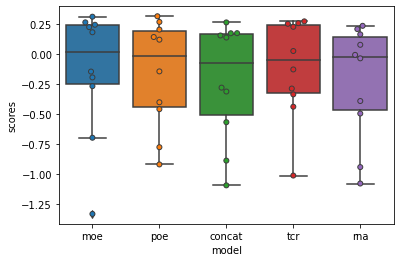

In [21]:
plot = sb.boxplot(data=results_total[results_total['metrics']=='R2_total'], y='scores', x='model')
sb.swarmplot(data=results_total[results_total['metrics']=='R2_total'], y='scores', x='model', 
             linewidth=1, edgecolor='gray')
results_total[results_total['metrics']=='R2_total'].groupby(['model'])['scores'].mean()

model
concat   -0.225027
moe      -0.142378
poe      -0.166436
rna      -0.227720
tcr      -0.118020
Name: scores, dtype: float64

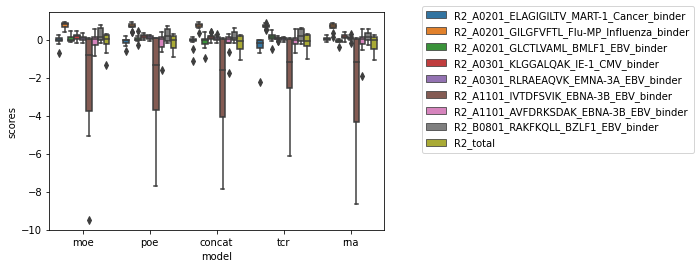

In [22]:
plot = sb.boxplot(data=results_total[results_total['metrics'].str.startswith('R2')], y='scores', x='model', 
                  hue='metrics')
#plot.set(ylim=(0, 2))
plot.legend(bbox_to_anchor=(1.1, 1.05))
results_total[results_total['metrics']=='R2_total'].groupby('model')['scores'].mean()

## Write to Supplementary

In [23]:
path_out = '../results/supplement/S1_benchmarking.xlsx'

with pd.ExcelWriter(path_out, mode='a') as writer:  
    results_10x_1.to_excel(writer, sheet_name='avidity_10x_donor1')
    results_10x_2.to_excel(writer, sheet_name='avidity_10x_donor2')